# Guided dFBA with uptake constraints from NMR

## Import packages

In [2]:
import csv
import math

import cobra as cb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Conversion factors

Conversion factors to transform signal to concentration.

These were determined by as described in the Methods section of our C.diff HRMAS pre-print. _These are estimates of concentration and should not be taken as precise values._

In [3]:
# Scale Factors - calculated from HMDB reference spectra
# = concentration / AVG(pk_intensities)
scale_f = {
    'glc' : 0.110683136*10,
    'ac'  : 0.089510168*10,
    'alaL': 0.089510168*10,
    'eto' : 0.110683136*10,
    'lacS': 0.089510168*10,
    'proL': 0.227765585,
    '5apn': 0.227765585,
}

## Some key functions

Helper functions:
1. Evaluate logistic function at timepoint.
1. Evaluate derivative of logistic function at timepoint.
1. Update the uptake/secretion reaction bounds with the logistic derivative. This function evaluates both the logistic curve and its derivative at the timepoint, updates the bounds, and returns both solutions. Pass in the logistic coefficients calculated with MATLAB.


In [4]:
def logistic (L, k, x0, C, x):
    """Evaluate the logistic function at point x."""
    return L/(1. + math.exp(-1*k*(x - x0))) + C

def ddx_logistic(L, k, x0, x):
    """Evaluate the derivative of the logistic function at point x."""
    return k*L*math.exp(-k*(x - x0))/(1. + math.exp(-1*k*(x - x0)))**2

def update_uptake_bounds(model, t, met, L, k, x0, C):
    """Update the uptake rate of exchange reaction at timepoint t."""
    logistic_sol = logistic(scale_f[met]*L, k, x0, scale_f[met]*C, t)
    uptake_rate = ddx_logistic(scale_f[met]*L, k, x0, t)
    if met == 'glc' or met == 'proL':
        rid = 'Ex_' + met
        uptake_rate *= -1.
        model.reactions.get_by_id(rid).upper_bound = uptake_rate
    else:
        rid = 'Sec_' + met
    model.reactions.get_by_id(rid).lower_bound = uptake_rate
    return logistic_sol, uptake_rate

def update_dependent_uptakes(model, sol, resolution):
    """Update maximum uptake rates of unconstrained metabolites."""
    for exch in model.exchanges:
        if sol.fluxes[exch.id] > 0:
            exch.upper_bound = max(0, exch.upper_bound - sol.fluxes[exch.id]*sol.objective_value*resolution*0.5)

## Plot function

In [5]:
def niceplot(df, t_max=48, ylabel='flux (mol/gDW/h)'):
    ax = df.plot(
        figsize=(14, 10),
        xticks=(range(0, t_max+1, 12)),
        xlim=(0, t_max),
        ylim=(0, None),
        fontsize=30,
        lw=5,
    )
    ax.set_xlabel('time (h)', fontsize=30, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=30, fontweight='bold')
    plt.xticks(ax.get_xticks(), weight='bold')
    plt.yticks(ax.get_yticks(), weight='bold')

## Main dFBA program

In [6]:
def dfba_main(specsheet, traced, modelfile='../../data/icdf834-mhmc.json', t_max=48, resolution=1):
    """Main dFBA function. Computes successive FBA solutions and plots the concentration, uptake rates, and tracked reaction fluxes.
       
       Arguments:
       specsheet -- path to tsv sheet containing logistic parameters
       traced -- list of reaction ids to be traced over the timecourse
       
       Keyword arguments:
       modelfile -- location of metabolic model
       t_max -- end timepoint in hours (default 48)
       resolution -- number of hours per dFBA sample (default 1)
       """
    print(f"""dFBA log: Begin dFBA analysis with sheet
          {specsheet.split('/')[-1]}, endpoint
          {t_max} hours, and resolution {resolution}.""")
    
    # Load metabolic model and logistic fit specs #
    print('dFBA log: loading model and specsheet...')
    model = cb.io.load_json_model(modelfile)
    model.reactions.ID_90.lower_bound = -1000
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03
    #model.reactions.ID_53.upper_bound = 0
    #model.reactions.ID_326.upper_bound = 0
    model.reactions.ID_393.upper_bound = 0
    model.reactions.ID_393.lower_bound = 0
    params = pd.read_csv(specsheet, header=0, index_col=0)
    
    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    uptakes = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    signals = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    rxnflux = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced]) # 
    rxnflux2 = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    
    print('dFBA log: simulation output begin.')
    for i, t in enumerate(timecourse):
        for met, data in params.iterrows():
            logi, ddxlogi = update_uptake_bounds(model, t, met, *data)
            uptakes.at[t, model.metabolites.get_by_id(met + '_c').name] = ddxlogi
            signals.at[t, model.metabolites.get_by_id(met + '_c').name] = logi
        #sol = cb.flux_analysis.pfba(model)
        #sol = cb.flux_analysis.geometric_fba(model)
        #sol = cb.flux_analysis.flux_variability_analysis(model)
        sol = model.optimize()
        if i % 10 == 0:  
            print(f'dFBA log: Time = {t}  (cycle {i}) \tFBA solution: {sol.fluxes["Ex_biomass"]}')
        if sol.fluxes['Ex_biomass'] < 0.0001:
            print(f'dFBA log: infeasible solution on cycle {i}.')
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = 0
        else:
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = abs(sol.fluxes[rid])
        #update_dependent_uptakes(model, sol, resolution)
        if i in [0, 12, 24, 36, 48]:
            # print(model.summary(solution=sol))
            print("time = " + str(i))
#             print(model.summary(solution=sol))
#             print(model.metabolites.get_by_id('gluD_c').summary(solution=sol))
#             print(model.metabolites.get_by_id('alaL_c').summary(solution=sol))

        #         for rxn in model.reactions:
#             if (rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']):
#                 cnc = init_cnc[rxn.id]
#                 if cnc > 0:
#                     deplete = sol.fluxes[rxn.id] / cnc
#                     rxn.upper_bound *= (1 - deplete)
#                     cnc *= (1 - deplete)
        
            
    print(f'Complete after {i} cycles ({t} hours). Final flux: {sol.fluxes["Ex_biomass"]}')
    niceplot(uptakes, ylabel='flux (mM/h)')
    plt.show()
#     plt.savefig('../../data/uptakes.png')
    niceplot(signals, ylabel='concentration (mM)')
    plt.show()
#     plt.savefig('../../data/concentrations.png')
    niceplot(rxnflux)
    plt.show()
#     plt.savefig('../../data/fluxes.png')
#     rxnflux.to_csv('../../data/fluxes.csv', sep='\t')

## Run using glucose data

dFBA log: Begin dFBA analysis with sheet
          glucose_coefficients.csv, endpoint
          48 hours, and resolution 1.
dFBA log: loading model and specsheet...
dFBA log: simulation output begin.
dFBA log: Time = 0  (cycle 0) 	FBA solution: 0.017993853128309343
time = 0
dFBA log: Time = 10  (cycle 10) 	FBA solution: 0.03129425595660155
time = 12
dFBA log: Time = 20  (cycle 20) 	FBA solution: 0.03217050859894261
time = 24
dFBA log: Time = 30  (cycle 30) 	FBA solution: 0.020205353084044312
time = 36
dFBA log: Time = 40  (cycle 40) 	FBA solution: 0.0016918514047084617
time = 48
Complete after 48 cycles (48 hours). Final flux: 0.00016867452465861628


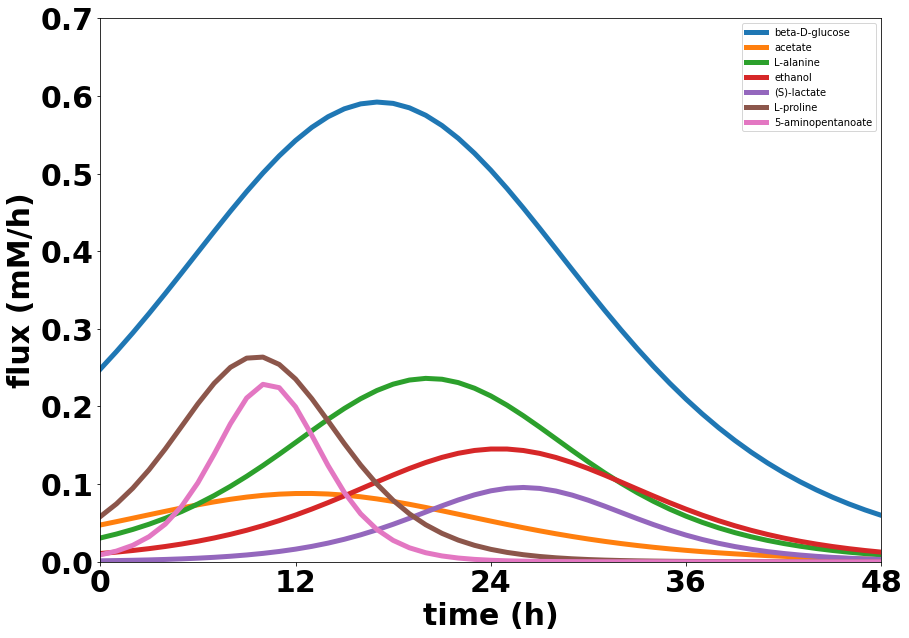

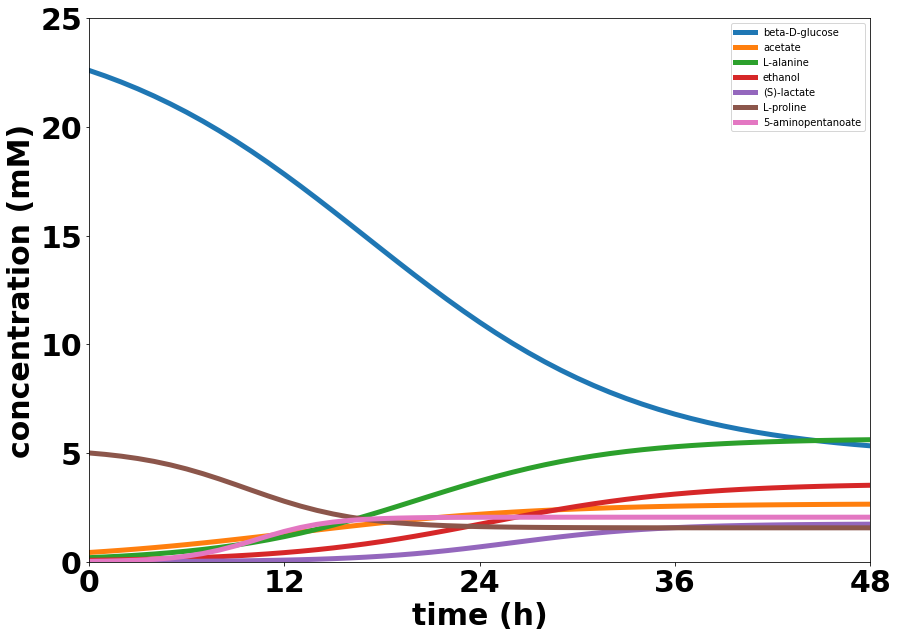

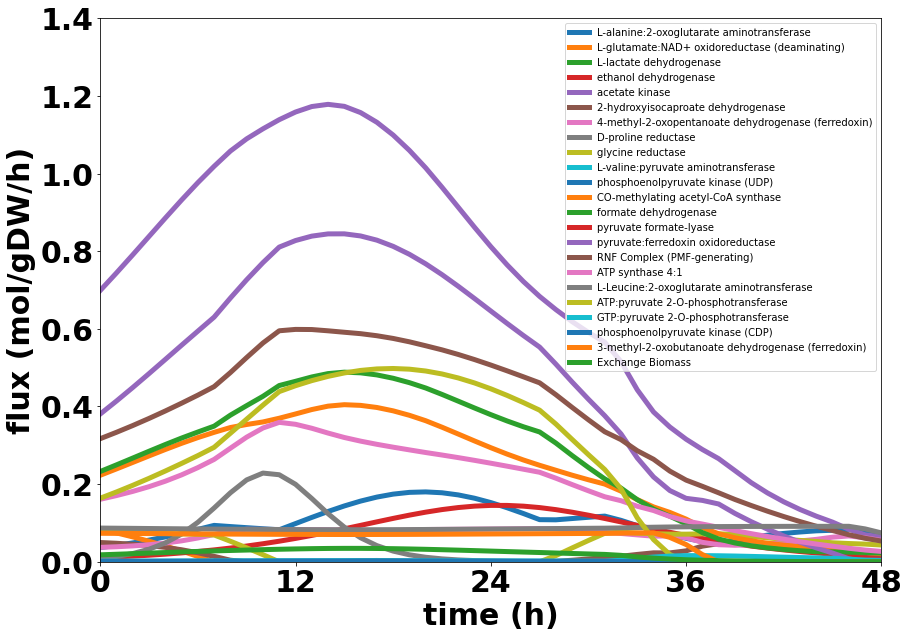

In [7]:
dfba_main("../../data/glucose_coefficients.csv", 
          ['ID_336', 'ID_575', 'ID_660', 'ID_383', 'ID_280', 'ID_685', 'RXN-19534', 'ID_314', 'ID_603', 'ID_369', 'ID_407', 'ID_326', 'ID_90', 'ID_36', 'ID_53', 'RNF-Complex', 'ATPsynth4_1', 
           'ID_28', 'ID_252', 'ID_126', 'ID_582', 'CPLX-8556', 'Ex_biomass'],
          t_max=48,
          resolution=1,
         )

In [11]:
def pyr_prop(specsheet, traced, modelfile='../../data/icdf834-mhmc.json', t_max=48, resolution=1):
    """Like dfba_main, but writes fluxes for pyruvate reactions."""
    model = cb.io.load_json_model(modelfile)
    model.reactions.ID_90.lower_bound = -1000
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03
    model.reactions.ID_393.upper_bound = 0
    model.reactions.ID_393.lower_bound = 0
    params = pd.read_csv(specsheet, header=0, index_col=0)
    
    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    uptakes = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    signals = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    rxnflux = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced]) # 
    rxnflux2 = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    
    pyr_rxns = []
    pyr_data = []
    
    print('dFBA log: simulation output begin.')
    for i, t in enumerate(timecourse):
        for met, data in params.iterrows():
            logi, ddxlogi = update_uptake_bounds(model, t, met, *data)
            uptakes.at[t, model.metabolites.get_by_id(met + '_c').name] = ddxlogi
            signals.at[t, model.metabolites.get_by_id(met + '_c').name] = logi
        sol = model.optimize()
        if i % 10 == 0:  
            print(f'dFBA log: Time = {t}  (cycle {i}) \tFBA solution: {sol.fluxes["Ex_biomass"]}')
        if sol.fluxes['Ex_biomass'] < 0.0001:
            print(f'dFBA log: infeasible solution on cycle {i}.')
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = 0
        else:
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = abs(sol.fluxes[rid])
        if i in [0, 10, 12, 20, 24, 30, 36, 48]:
            print("time = " + str(i))
            print(model.metabolites.get_by_id('pyr_c').summary(solution=sol))
#             print(model.summary())

        pyr = model.metabolites.pyr_c
        localdata = {}
        for rxn in model.reactions:
            if (pyr in rxn.reactants and sol.fluxes[rxn.id] > 1E-5) or (pyr in rxn.products and sol.fluxes[rxn.id] < -1E-5):
                localdata[rxn.id] = rxn.metabolites[pyr] * sol.fluxes[rxn.id]
        pyr_data.append(localdata)
        for k in localdata:
            pyr_rxns.extend([k for k in localdata])
        
    rids = list(set(pyr_rxns))
    with open('../../data/pyrflux.txt', 'w') as wf:
        wf.write('time\t' + '\t'.join(rids) + '\n')
        for i, t in enumerate(timecourse):
            wf.write(str(t))
            for rxn in rids:
                wf.write('\t' + str(pyr_data[i].get(rxn, 0)))
            wf.write('\n')
        

In [12]:
def ac_prop(specsheet, traced, modelfile="../../data/icdf834-mhmc.json", t_max=48, resolution=1):
    """Like dfba_main, but writes fluxes for acetate reactions.
    Plot with plotFluxArea.m
    """
    model = cb.io.load_json_model(modelfile)
    model.reactions.ID_90.lower_bound = -1000
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03
    model.reactions.ID_393.upper_bound = 0
    model.reactions.ID_393.lower_bound = 0
    params = pd.read_csv(specsheet, header=0, index_col=0)
    
    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    uptakes = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    signals = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_c').name for mid in params.index])
    rxnflux = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced]) # 
    rxnflux2 = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    
    ac_rxns_in = []
    ac_data_in = []
    ac_rxns_ot = []
    ac_data_ot = []
    
    print('dFBA log: simulation output begin.')
    for i, t in enumerate(timecourse):
        for met, data in params.iterrows():
            logi, ddxlogi = update_uptake_bounds(model, t, met, *data)
            uptakes.at[t, model.metabolites.get_by_id(met + '_c').name] = ddxlogi
            signals.at[t, model.metabolites.get_by_id(met + '_c').name] = logi
        sol = model.optimize()
        if i % 10 == 0:  
            print(f'dFBA log: Time = {t}  (cycle {i}) \tFBA solution: {sol.fluxes["Ex_biomass"]}')
        if sol.fluxes['Ex_biomass'] < 0.0001:
            print(f'dFBA log: infeasible solution on cycle {i}.')
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = 0
        else:
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = abs(sol.fluxes[rid])
        if i in [0, 12, 20, 24, 36, 48]:
            print("time = " + str(i))
            print(model.metabolites.get_by_id('acoa_c').summary(solution=sol))

        ac = model.metabolites.acoa_c
        localdata_in = {}
        localdata_ot = {}
        for rxn in model.reactions:
            if (ac in rxn.reactants and sol.fluxes[rxn.id] > 1E-5) or (ac in rxn.products and sol.fluxes[rxn.id] < -1E-5):
                localdata_ot[rxn.id] = rxn.metabolites[ac] * sol.fluxes[rxn.id]
            if (ac in rxn.reactants and sol.fluxes[rxn.id] < -1E-5) or (ac in rxn.products and sol.fluxes[rxn.id] > 1E-5):
                localdata_in[rxn.id] = rxn.metabolites[ac] * sol.fluxes[rxn.id]
        ac_data_in.append(localdata_in)
        ac_data_ot.append(localdata_ot)
        for k in localdata_in:
            ac_rxns_in.extend([k for k in localdata_in])
        for k in localdata_ot:
            ac_rxns_ot.extend([k for k in localdata_ot])
        
    rids_in = list(set(ac_rxns_in))
    rids_ot = list(set(ac_rxns_ot))
    with open('../../data/acflux_in.txt', 'w') as wfi, open('../../data/acflux_ot.txt', 'w') as wfo:
        wfi.write('time\t' + '\t'.join(rids_in) + '\n')
        wfo.write('time\t' + '\t'.join(rids_ot) + '\n')
        for i, t in enumerate(timecourse):
            wfi.write(str(t))
            wfo.write(str(t))
            for rxn in rids_in:
                wfi.write('\t' + str(ac_data_in[i].get(rxn, 0)))
            for rxn in rids_ot:
                wfo.write('\t' + str(ac_data_ot[i].get(rxn, 0)))
            wfi.write('\n')
            wfo.write('\n')
        

In [13]:
pyr_prop("../../data/glucose_coefficients.csv", 
          ['ID_336', 'ID_575', 'ID_660', 'ID_383', 'ID_280', 'ID_685', 'RXN-19534', 'ID_314', 'ID_603', 'ID_369', 'ID_407', 'ID_326', 'ID_90', 'ID_36', 'ID_53', 'RNF-Complex', 'ATPsynth4_1', 
           'ID_28', 'ID_252', 'ID_126', 'ID_582', 'CPLX-8556', 'Ex_biomass'],
          t_max=48,
          resolution=1,
         )

dFBA log: simulation output begin.
dFBA log: Time = 0  (cycle 0) 	FBA solution: 0.017993853128309343
time = 0
pyr_c
=====
Formula: C3H4O3

Producing Reactions
-------------------
Percent      Flux  Reaction                                       Definition
  0.37%  0.001592    ID_126                gdp_c + pepyr_c <=> gtp_c + pyr_c
  2.81%   0.01199    ID_188 atp_c + pi_c + pyr_c <=> amp_c + pepyr_c + ppi_c
 38.44%    0.1637    ID_252                adp_c + pepyr_c <=> atp_c + pyr_c
  0.06% 0.0002375     ID_26              dgtp_c + pyr_c <=> dgdp_c + pepyr_c
  0.24%  0.001039    ID_582                cdp_c + pepyr_c --> ctp_c + pyr_c
  0.14% 0.0005803    ID_632              datp_c + pyr_c <=> dadp_c + pepyr_c
 57.93%    0.2468 Trans_glc              glc_e + pepyr_c --> glc6p_c + pyr_c

Consuming Reactions
-------------------
Percent       Flux           Reaction                                                                   Definition
  8.61%   -0.03667             ID_336            